In [1]:
import pandas as pd
import datetime
from pandas import Series
from pandas import datetime
import matplotlib
import numpy as np
from matplotlib import pyplot as plt
from statsmodels.tsa.arima_model import ARIMA
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_pacf
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
plt.style.use('fivethirtyeight')
%matplotlib inline
 
production=pd.read_pickle("./processed/production_all_dates_and_variables.pkl")
keep_these=['Wind_KWH',
            'Solar_KWH',
            'Wind_Speed_AT_WINDFARM',
            'Solar_Elevation',
            'Cloud_Cover_Fraction',
            'Dew_Point',
            'Humidity_Fraction',
            'Precipitation',
            'Pressure',
            'Temperature',
            'Visibility',
            'Wind_Speed_AT_SOLARRAY']
production=production[keep_these]
#fill the date and time gaps
production = production.resample("60min").asfreq()
production.to_pickle("./processed/production_full_date_range_pre_impute.pkl")



In [2]:
"""
Implement an imputation scheme for each variable.


Dependent Variables - no imputation
solar - if nighttime, zero
wind - ???
=========================================
'Wind_KWH',
'Solar_KWH',

Dependent Variables - impute as described
CHECK SPARSITY OF VALUES PRIOR TO IMPUTING
=========================================
'Wind_Speed_AT_WINDFARM', - high variance, 
'Solar_Elevation', # Removing, as there is no good way to aggregate this by day, nor is it necessarily relevant except
                     as a performance measure of the solar array, which is not under analysis.
'Cloud_Cover_Fraction', - Average
'Dew_Point', - Average
'Humidity_Fraction', - Average
'Precipitation', - Average
'Pressure', - Average
'Temperature', - Average
'Visibility', - Average
'Wind_Speed_AT_SOLARRAY' - Average

Note: We should do inter-day analysis as well, if possible.

""" 

# Create dataset for seasonality of solar KWH by day.

solar_prod=production['Solar_KWH']
solar_prod_by_day = solar_prod.resample("D").sum().to_frame('Solar_KWH')
solar_prod_by_day.to_pickle("./processed/solar_prod_by_day.pkl")

independent_vars=['Cloud_Cover_Fraction',
                  'Dew_Point',
                  'Humidity_Fraction',
                  'Precipitation',
                  'Pressure',
                  'Temperature',
                  'Visibility',
                  'Wind_Speed_AT_SOLARRAY']

indep_vars=production[independent_vars]
for field in independent_vars:
    # consumption_master = consumption_master.join(calendar, how='outer', sort=True)
    # For each field, aggregate by day, then join to solar_prod
    tmp=pd.DataFrame(data=indep_vars[field])
    tmp.dropna(axis=0, inplace=True)
    tmp=tmp.loc[tmp[field]!='nan'] # How we got text 'nan' in here, I do not know, but remove them.
    tmp=pd.to_numeric(tmp[field], downcast='float')
    # Averaging the remaining values by day should yield a useful metric for modeling, even if
    # it would be meaningless from a real weather-reporting context. 
    # We are imposing the same limitation on all variables, so should still be representative.
    tmp=tmp.resample("D").mean().to_frame(field)
    #print(tmp.head())
    solar_prod_by_day=solar_prod_by_day.join(tmp, how='left', sort=True)
    
#print(solar_prod_by_day.head())


# Now, we need to interpolate missing values.

def interpolate_gaps(values, limit=None):
    """
    Fill gaps using linear interpolation, optionally only fill gaps up to a
    size of `limit`, courtesy of StackOVerflow:
    https://stackoverflow.com/questions/36455083/working-with-nan-values-in-matplotlib
    """
    values = np.asarray(values)
    i = np.arange(values.size)
    valid = np.isfinite(values)
    filled = np.interp(i, i[valid], values[valid])

    if limit is not None:
        invalid = ~valid
        for n in range(1, limit+1):
            invalid[:-n] &= invalid[n:]
        filled[invalid] = np.nan
    return filled


columns={}
dates=solar_prod_by_day.index.values
columns['Date']=dates
for field in list(solar_prod_by_day):
    raw=solar_prod_by_day[field].values
    filled = interpolate_gaps(raw, limit=2)
    columns[field]=filled

solar_prod_by_day_fnl=pd.DataFrame.from_dict(columns)
solar_prod_by_day_fnl.set_index('Date', inplace=True)
solar_prod_by_day_fnl.to_pickle("./processed/solar_prod_by_day_w_interpolation.pkl")
print(solar_prod_by_day_fnl.head())


                Solar_KWH  Cloud_Cover_Fraction  Dew_Point  Humidity_Fraction  \
Date                                                                            
2010-01-04   20084.160000              1.000000  -8.300000           0.698400   
2010-01-05  111402.100000              1.000000  -7.000000           0.789400   
2010-01-06  163901.380000              1.000000  -6.950000           0.768500   
2010-01-07   95813.460000              0.985714  -6.442857           0.865729   
2010-01-08  116167.524153              0.987500 -11.062500           0.723737   

            Precipitation    Pressure  Temperature  Visibility  \
Date                                                             
2010-01-04       0.000000  992.050049    -3.600000   16.093000   
2010-01-05       0.000000  992.112488    -3.875000   15.087251   
2010-01-06       0.000000  993.799988    -3.475000   16.093000   
2010-01-07       0.071429  991.649963    -4.528572   11.954858   
2010-01-08       0.000000  996.01251

In [ ]:
# For every complete year in the dataset, we will:
# - create a dataframe for that year
# - add it to a list of dataframes
# - use that list to do n-fold validation

min_dte = solar_prod_by_day_fnl.index.min()
max_dte = solar_prod_by_day_fnl.index.max()
tmp_dte = min_dte
next_year = min_dte + pd.DateOffset(years=1)
year_cnt=0
time_left = ((max_dte-min_dte).days) #.astype(int)
production_by_year={}

while time_left > 0:
    time_left = ((max_dte-next_year).days)
    if time_left > 0:
        tmp_yr=str(tmp_dte.year)
        tmp_data=solar_prod_by_day_fnl.loc[(solar_prod_by_day_fnl.index.year == tmp_dte.year)]
        month_count = len(tmp_data.index.month.unique())
        if month_count == 12:
            production_by_year[tmp_yr]=tmp_data
    year_cnt += 1
    next_year = tmp_dte + pd.DateOffset(years=1)
    tmp_dte += pd.DateOffset(years=1)


In [ ]:
# Plot each year, see what it looks like.


for year in production_by_year:
    for field in list(production_by_year[year]):
        #field='Dew_Point'
        chtitle=year + ' ' + field
        print(chtitle)
        #production_by_year[year][field].plot(figsize=(15, 6), title=chtitle)
        plt.scatter(production_by_year[year].index, production_by_year[year][field])
        plt.show()

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

for year in production_by_year:
    for field in list(production_by_year[year]):
        #field='Dew_Point'
        chtitle=year + ' ' + field
        production_by_year[year][field].plot(figsize=(15, 6),
                                             title=chtitle)
        plt.show()
        for frequency in range(3, 20):
            try:
                result = seasonal_decompose(production_by_year[year][field], model='additive', freq=frequency);
                break
            except ValueError:
                continue
        imgname="{}_freq_{}".format(chtitle, frequency)
        print(imgname)
        result.plot()
        plt.savefig("./Images/" + imgname + '.png')

# We can see in plots that there is some seasonality component.
# We need to decompose this.
# From: https://medium.com/@josemarcialportilla/using-python-and-auto-arima-to-forecast-seasonal-time-series-90877adff03c



In [ ]:
from statsmodels.tsa.arima_model import ARIMA
# Lets do some ARIMA and SARIMA!
# Source Reference: https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/
# Excellent resource for explaining ARIMA in general. 
# https://people.duke.edu/~rnau/411arim.htm

series=production_by_year['2010']['Solar_KWH']
model = ARIMA(series, order=(1,1,2))
model_fit = model.fit(disp=0)
print(model_fit.summary())
# plot residual errors
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()
residuals.plot(kind='kde')
plt.show()
print(residuals.describe())

In [ ]:
from pandas import datetime
from matplotlib import pyplot
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
 
#=======================================================================
# Populate train and test - try different approaches.
# Good reference: https://www.digitalocean.com/community/tutorials/a-guide-to-time-series-forecasting-with-arima-in-python-3
#=======================================================================

train_data=solar_prod_by_day_fnl['Solar_KWH'].loc[(solar_prod_by_day_fnl.index.year == 2012)]
train=train_data.values

test_data=solar_prod_by_day_fnl['Solar_KWH'].loc[(solar_prod_by_day_fnl.index.year == 2013)]
test=test_data.values

#=======================================================================

history = [x for x in train]
predictions = list()
for t in range(len(test)):
    model = ARIMA(history, order=(0,2,1))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    #print('predicted=%f, expected=%f' % (yhat, obs))
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)
# plot
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()

In [ ]:
#for year in solar_prod_by_day_fnl.index.year.unique():
#    print(year)
#print(solar_prod_by_day_fnl.index.year.max())
train_years=[2010, 2011, 2012]
sample_data=solar_prod_by_day_fnl['Solar_KWH'].loc[(solar_prod_by_day_fnl.index.year.isin(train_years))]
print(sample_data.index.year.unique())
print(sample_data.head())

In [4]:
import warnings
import itertools
#import pandas as pd
#import numpy as np
import statsmodels.api as sm
#import matplotlib.pyplot as plt
#plt.style.use('fivethirtyeight')

# From: 
# https://www.digitalocean.com/community/tutorials/a-guide-to-time-series-forecasting-with-arima-in-python-3

# Lets split the data into 2 years train, one test, across years. Assumption: That any long-
# term weather trend will not manifest materially within a three year timeframe.

train_years=[2010, 2011, 2012]
test_years=[2013]
#start=2010
#end=start+1

#train_data=solar_prod_by_day_fnl['Solar_KWH'].loc[(solar_prod_by_day_fnl.index.year == start)]
train_data=solar_prod_by_day_fnl['Solar_KWH'].loc[(solar_prod_by_day_fnl.index.year.isin(train_years))]
train=train_data.values

#test_data=solar_prod_by_day_fnl['Solar_KWH'].loc[(solar_prod_by_day_fnl.index.year == end)]
test_data=solar_prod_by_day_fnl['Solar_KWH'].loc[(solar_prod_by_day_fnl.index.year.isin(test_years))]
test=test_data.values

# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], len(train)) for x in list(itertools.product(p, d, q))]

warnings.filterwarnings("ignore") # specify to ignore warning messages
count=1
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(train,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()
            if count==1:
                tmp_best=results.aic
                count+=1
            else:
                if tmp_best > results.aic:
                    tmp_best=results.aic
                    tmp_best_param=param
                    tmp_best_seasonal=param_seasonal
                    count+=1
                else:
                    count+=1
                    
            print('ARIMA{}x{}12 - AIC:{} - best AIC: {} - Iteration: {}'.format(param,
                                                                                param_seasonal,
                                                                                results.aic,
                                                                                tmp_best,
                                                                                count))
            
        except:
            continue

print("Best param: {} Best Seasonal Param: {} best AIC: {}".format(tmp_best_param,
                                                                   tmp_best_seasonal,
                                                                   tmp_best))
    

ARIMA(0, 0, 0)x(0, 0, 0, 1093)12 - AIC:32964.10324560931 - best AIC: 32964.10324560931 - Iteration: 2
ARIMA(0, 0, 1)x(0, 0, 0, 1093)12 - AIC:32388.38244282592 - best AIC: 32388.38244282592 - Iteration: 3
ARIMA(0, 1, 0)x(0, 0, 0, 1093)12 - AIC:31520.340684826042 - best AIC: 31520.340684826042 - Iteration: 4
ARIMA(0, 1, 1)x(0, 0, 0, 1093)12 - AIC:31085.698939975795 - best AIC: 31085.698939975795 - Iteration: 5
ARIMA(1, 0, 0)x(0, 0, 0, 1093)12 - AIC:31472.935182494246 - best AIC: 31085.698939975795 - Iteration: 6
ARIMA(1, 0, 1)x(0, 0, 0, 1093)12 - AIC:31118.675707064034 - best AIC: 31085.698939975795 - Iteration: 7
ARIMA(1, 1, 0)x(0, 0, 0, 1093)12 - AIC:31367.325110227746 - best AIC: 31085.698939975795 - Iteration: 8
ARIMA(1, 1, 1)x(0, 0, 0, 1093)12 - AIC:31044.037789438553 - best AIC: 31044.037789438553 - Iteration: 9
Best param: (1, 1, 1) Best Seasonal Param: (0, 0, 0, 1093) best AIC: 31044.037789438553


In [5]:
mod = sm.tsa.statespace.SARIMAX(train,
                                order=tmp_best_param,
                                seasonal_order=tmp_best_seasonal,
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2202      0.036      6.176      0.000       0.150       0.290
ma.L1         -0.9302      0.014    -67.473      0.000      -0.957      -0.903
sigma2      1.559e+11   2.37e-14   6.57e+24      0.000    1.56e+11    1.56e+11


In [ ]:
test_order=(0,2,0)
test_seasonal_order=(0, 0, 0, 30)

mod = sm.tsa.statespace.SARIMAX(train,
                                order=test_order,
                                seasonal_order=test_seasonal_order,
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

print(results.summary().tables[1])

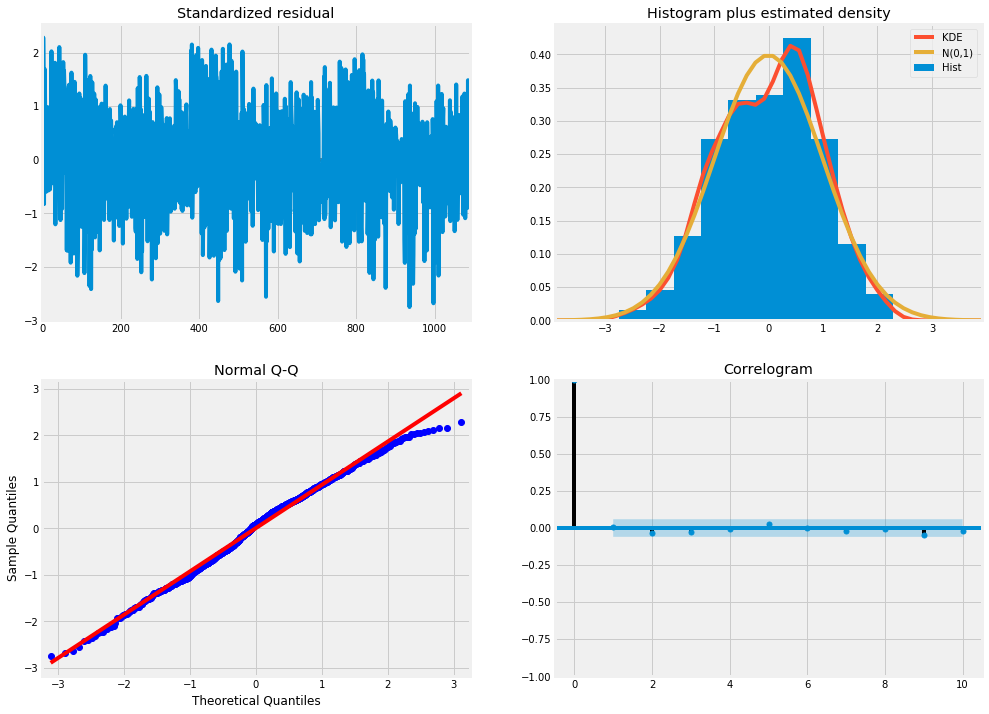

In [10]:
#results.plot_diagnostics(figsize=(15, 12))
#plt.show()
imgname="SARIMA_train_{}_test_{}_param_{}_seasonal_{}".format(2010, 2013, tmp_best_param, tmp_best_seasonal)
results.plot_diagnostics(figsize=(15, 12)).savefig("./Images/" + imgname + '.png')

In [7]:
# Lets keep the 2010 model.

print(results.specification)

"""pred = results.get_prediction(start=pd.to_datetime('2011-01-01'), dynamic=False)
pred_ci = pred.conf_int()

ax = train['Solar_KWH':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7)

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('Solar KWH')
plt.legend()

plt.show()"""

{'seasonal_periods': 1093, 'measurement_error': False, 'time_varying_regression': False, 'simple_differencing': False, 'enforce_stationarity': False, 'enforce_invertibility': False, 'hamilton_representation': False, 'order': (1, 1, 1), 'seasonal_order': (0, 0, 0, 1093), 'k_diff': 1, 'k_seasonal_diff': 0, 'k_ar': 1, 'k_ma': 1, 'k_seasonal_ar': 0, 'k_seasonal_ma': 0, 'k_ar_params': 1, 'k_ma_params': 1, 'trend': None, 'k_trend': 0, 'k_exog': 0, 'mle_regression': False, 'state_regression': False}


"pred = results.get_prediction(start=pd.to_datetime('2011-01-01'), dynamic=False)\npred_ci = pred.conf_int()\n\nax = train['Solar_KWH':].plot(label='observed')\npred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7)\n\nax.fill_between(pred_ci.index,\n                pred_ci.iloc[:, 0],\n                pred_ci.iloc[:, 1], color='k', alpha=.2)\n\nax.set_xlabel('Date')\nax.set_ylabel('Solar KWH')\nplt.legend()\n\nplt.show()"

In [ ]:
"""
Our primary concern is to ensure that the residuals of our model are uncorrelated and 
normally distributed with zero-mean. If the seasonal ARIMA model does not satisfy these properties, 
it is a good indication that it can be further improved.

In this case, our model diagnostics suggests that the model residuals are roughly normally 
distributed based on the following:

In the top right plot, we see that the red KDE line does follows the N(0,1) line, which 
is the standard notation for a normal distribution with mean 0 and standard deviation of 1), except for a 
spike between 0 and 1. This is a good indication that the residuals are roughly normally distributed.

The qq-plot on the bottom left shows that the ordered distribution of residuals (blue dots)
follows the linear trend of the samples taken from a standard normal distribution with N(0, 1).
This is a decent indication that the residuals are normally distributed.

The residuals over time (top left plot) don't display any obvious seasonality and appear to be white noise.

This is confirmed by the autocorrelation (i.e. correlogram) plot on the bottom right,
which shows that the time series residuals have low correlation with lagged versions of itself.
Those observations lead us to conclude that our model produces a satisfactory fit that could help us
understand our time series data and forecast future values.
"""